## 197 - Influential values


In [2]:

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

from pygam import LinearGAM, s, l
from pygam.datasets import wage


import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import linregress


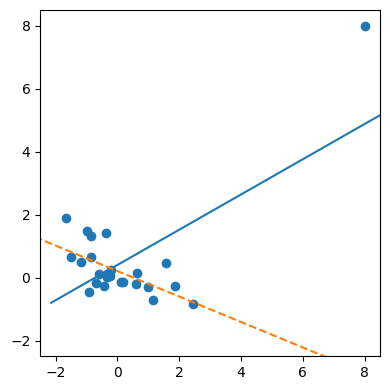

In [4]:
# This code is demonstrating the effect of an outlier on linear regression:
    # The purpose of this code is to visually demonstrate how a single outlier can dramatically affect the results of linear regression. 
    # The solid line (regression with outlier) will be pulled strongly toward the point (8,8), 
    # while the dashed line (regression without outlier) will better fit the underlying pattern in the rest of the data.


    # Data Generation:
    # The code first creates data with a slight negative correlation (slope of -1/5) plus random noise.
np.random.seed(5)
x = np.random.normal(size=25)
y = - x / 5 + np.random.normal(size=25)


    # Outlier Introduction:
    # This deliberately creates an outlier by setting the first point to (8,8), far from the rest of the data.
x[0] = 8
y[0] = 8


    # Helper Function:
    # This function calculates the endpoints of a line given its slope and intercept, using the plot's x-axis limits.
    # The function's purpose is to convert a line's mathematical form (slope and intercept) into plottable coordinates.
    # The function takes three parameters:
    #    - slope: The slope of the line (rise/run)
    #    - intercept: The y-intercept (where the line crosses the y-axis)
    #    - ax: The matplotlib axis object where the line will be plotted

def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""

        # "ax.get_xlim()" returns a tuple of the current x-axis limits (min and max values). 
        # For example, in this  code it returns (-2.5, 8.5)
        # "np.array(ax.get_xlim())" converts these limits to a NumPy array with two values
    x_vals = np.array(ax.get_xlim())

        #The function then returns a tuple of:
        #    - First element: the x-coordinates (just the axis limits)
        #    - Second element: the calculated y-coordinates using the line equation y = mx + b
        
    return (x_vals, intercept + slope * x_vals)
      
        # So if your slope was 2 and intercept was 1, with x-limits of (-2.5, 8.5), it would return:
        #    - x_vals: array([-2.5, 8.5])
        #    - y_vals: array([-4.0, 18.0]) (calculated as 1 + 2 * x_vals)
        # When this is passed to plot() using plot(*abline(...)), 
        # the asterisk unpacks these two arrays as separate arguments, 
        # telling matplotlib to draw a line through these two points
        # This is a common technique in plotting because it's more efficient than calculating many points along the line - 
        # you just need the endpoints and matplotlib handles drawing the line between them.

        # For example, if the regression calculates:
        # slope = 0.5
        # intercept = 1.0
        # abline(0.5, 1.0, ax)    returns: (array([-2, 2]), array([0, 2]))
        # When plotted, this creates a line from point (-2, 0) to point (2, 2), representing the best fit line through the data points.


    # Visualization:
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(x, y)


# Two Regression Lines:
    # # First regression with outlier:
    # "linregress" is a function from scipy.stats that performs linear regression
    # It returns 5 values: slope, intercept, r-value, p-value, and standard error
    # x and y are arrays of values for the points, enstablished above
    # we're only keeping the slope and intercept values we need for plotting (we discard the others wirh "_"

slope, intercept, _, _, _ = linregress(x, y)

    # "abline(slope, intercept, ax)" returns a tuple of (x_values, y_values)
    # The * operator unpacks this tuple into separate arguments
    # It's equivalent to writing: ax.plot(x_values, y_values)
    # this unpacks the tuple returned by the "abline" function and draws the regression line on the plot
ax.plot(*abline(slope, intercept, ax))

    # Second regression without outlier:
    # This repeats the same operation but passes the x and y arrays without the first point (that's where we set the outlier)
slope, intercept, _, _, _ = linregress(x[1:], y[1:])
ax.plot(*abline(slope, intercept, ax), '--')


# Plot Formatting:
    # Sets the axis limits and displays the plot.
ax.set_xlim(-2.5, 8.5)
ax.set_ylim(-2.5, 8.5)

plt.tight_layout()
plt.show()

In [6]:
type(x)

numpy.ndarray

## Influence Plot

The package statsmodel provides a number of plots to analyze the data point influence

An influence plot or bubble plot combines standardized residuals, the hat-value, and Cook’s distance in a single plot.


In [9]:
## Code from "194" necessary for further developments

house = pd.read_csv('house_sales.csv', sep='\t')

# First we filter the "house" dataset and create a new subset dataset
house_98105 = house.loc[house['ZipCode'] == 98105, ]

    # These lines establish our model's ingredients. The predictors are the features we think influence house prices, 
    # while the outcome is what we're trying to predict (the adjusted sale price).

    # We set the predicting variables
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']

    # And the outcome variable
outcome = 'AdjSalePrice'

    # This creates our regression model, 
    # we're using .assign(const=1) to add a constant term (also known as an intercept) to our predictors. 
    # This is like giving our model a starting point, a base price that gets adjusted up or down based on the house's features. 

house_outlier = sm.OLS(house_98105[outcome], house_98105[predictors].assign(const=1))

    # These lines actually run the regression and show us the results. 
    # The model finds the best way to predict house prices in zip code 98105 using our chosen features.

result_98105 = house_outlier.fit()
print(result_98105.summary())


                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     238.7
Date:                Sat, 18 Jan 2025   Prob (F-statistic):          1.69e-103
Time:                        20:01:47   Log-Likelihood:                -4226.0
No. Observations:                 313   AIC:                             8464.
Df Residuals:                     307   BIC:                             8486.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   209.6023     24.408      8.587

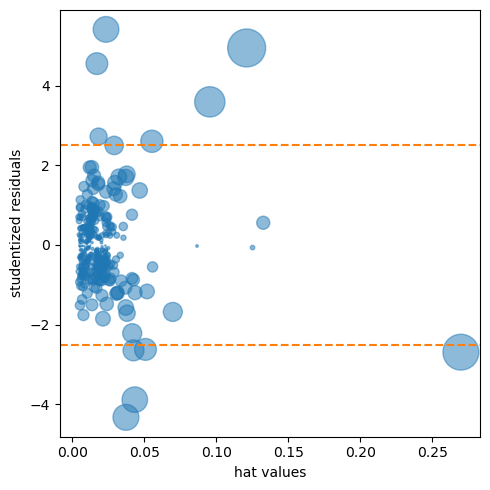

x-axis point of concern:  0.038338658146964855


In [10]:
# This code creates an influence plot, which is a diagnostic tool used in regression analysis 
# to identify influential observations and potential outliers
# It combines:
#    - Studentized residuals (on the y-axis)
#    - Hat values or leverage (on the x-axis)
#    - Cook's distance (shown by the size of the points)


# The "OLSInfluence" class from statsmodels calculates these diagnostic statistics 
    # from your regression model ("result_98105" in this case)

    # The OLSInfluence class returns an object containing various diagnostic statistics that help us assess 
    # the influence of individual observations in our regression model. Let me explain the key attributes this object provides:
    #    - influence.hat_matrix_diag (used as x):
                # These are the diagonal elements of the "hat matrix" (also called the projection matrix or leverage matrix). 
                # The hat matrix maps the observed values to their predicted values in the regression. 
                # Each diagonal element represents how much leverage (or potential for influence) each observation has, 
                # based solely on its values for the predictor variables. The values range from 0 to 1, 
                # with larger values indicating more leverage.
    #    - influence.resid_studentized_internal (used as y):
                # These are the studentized residuals, which are the residuals (differences between observed and predicted values) 
                # that have been standardized by dividing by their estimated standard deviation. 
                # This standardization makes the residuals more comparable across observations. 
                # They follow approximately a t-distribution when the model assumptions are met.
    #    - influence.cooks_distance: 
                # This is Cook's distance, which measures the overall influence of each observation by combining information 
                # about both the residual and leverage. It shows how much the regression coefficients would change if this 
                # observation were removed from the dataset. Larger values indicate more influential points.
    # Others, not used in this code:
    #    - influence.resid_studentized_external: 
                # These are externally studentized residuals, similar to the internal version but calculated by 
                # leaving out each observation one at a time. They can be more sensitive for detecting outliers.
    #     - influence.dfbetas: 
                # These show how much each regression coefficient changes (in standard errors) when each observation 
                # is removed from the regression.
    #    - influence.dffits: 
                # This measures the change in predicted values when each observation is removed from the model fitting.

# SUMMARY:
    # The hat values tell us which observations have unusual combinations of predictor values
    # The studentized residuals tell us which observations aren't well predicted by our model
    # Cook's distance tells us which observations are most influential in determining our regression results


influence = OLSInfluence(result_98105)


    # We create the plot:
    # The point size is scaled by the square root of Cook's distance 
    # (multiplied by 1000 for visibility because using the raw values might make some points too large).

fig, ax = plt.subplots(figsize=(5, 5))

    # lines:
ax.axhline(-2.5, linestyle='--', color='C1')
ax.axhline(2.5, linestyle='--', color='C1')
ax.scatter(influence.hat_matrix_diag, influence.resid_studentized_internal, 
           s=1000 * np.sqrt(influence.cooks_distance[0]),
           alpha=0.5)

ax.set_xlabel('hat values')
ax.set_ylabel('studentized residuals')

plt.tight_layout()
plt.show()


    # INTERPRETATION:
# When interpreting this plot, you should look for:
#     - Points far from the horizontal axis (large residuals)
#     - Points far to the right (high leverage)
#     - Large points (high Cook's distance)
# These points warrant closer investigation as they might be influencing your regression results in potentially problematic ways. 
# Points that exhibit all three characteristics (large residual, high leverage, and large Cook's distance) are especially worth examining.

# This is a map that helps us identify observations that might be affecting our regression results in important ways. 

    # Layout:
# The plot is divided into regions by the dashed lines at +2.5 and -2.5 on the y-axis, 
# creating what we might think of as "safe" and "investigate" zones. 
# Imagine these like warning lines on a dashboard - when points cross these lines, they deserve our attention.

    # Horizontal Position (Hat Values/Leverage):
# Points that are far to the right have high leverage, meaning they have unusual combinations of predictor variables. 
# Think of leverage like a mechanical lever - the further out a point is, the more power it has to move your regression line. 
# A common threshold for concerning leverage is 2(p+1)/n, where p is the number of parameters (predictors + 1 for intercept)
# and n is your sample size. 
# Points beyond this threshold might have too much influence on your model's predictions.
# in this case, the point is: 0.03833
concern_x = (2*( len(predictors)+1))/house_98105.shape[0]
print("x-axis point of concern: ",concern_x)

    # Vertical Position (Studentized Residuals):
# Points far from 0 vertically are outliers in terms of your dependent variable. 
# If you think of your regression line as trying to "predict" each point, these are the points it predicted poorly. 
# Points beyond the ±2.5 dashed lines are like students scoring unusually high or low on a standardized test: they warrant special attention.

    # Point Size (Cook's Distance):
# The size of each point represents its overall influence on your regression results. 
# Larger points are like heavyweight boxers - they pack more punch in terms of affecting your regression coefficients. 
# A common rule of thumb is to investigate points with Cook's distance greater than 4/n, where n is your sample size.

# Here's what to look for:

# Bad Leverage Points:
#     - These are points in the upper right or lower right quadrants
#     - They have both high leverage AND large residuals
#     - They're especially problematic because they're pulling your regression line in potentially misleading directions
#     - Think of these like a strong person pushing in the wrong direction

# Good Leverage Points:
#     - These are points far to the right but close to 0 on the vertical axis
#     - They have high leverage but follow the pattern of other data
#     - These aren't necessarily problematic - they might actually be helping define a true relationship

# Vertical Outliers:
#     - These are points far from 0 vertically but not far right
#     - They don't fit the pattern but don't have much leverage
#     - They might indicate interesting cases worth investigating but usually don't distort your overall regression much

# Concerns:
# The most concerning points are those that show up as large circles (high Cook's distance) in the outer regions of the plot. 
# These are the "triple threats" - high leverage, large residuals, and substantial influence on your regression results.

# When you find concerning points, the next steps would be to:
#     - Verify these observations for data entry errors
#     - Understand why these cases are different (there might be meaningful reasons)
#     - Consider how robust your conclusions are with and without these observations
#     - Document any decisions about keeping or removing these points






In [12]:
# Here we want to:
#     - Create a side-by-side comparison of regression coefficients
#     - Shows how the coefficients change when influential points are removed
#     - Helps assess the sensitivity of your model to influential observations


    # Creates a boolean mask identifying points with Cook's distance less than 0.08
    # Cook's distance is a measure of how much a single observation influences the regression model
    # Points with high Cook's distance are considered influential outliers
mask = [distance < .08 for distance in influence.cooks_distance[0]]

    # Creates a new dataset EXCLUDING the influential points (where Cook's distance ≥ 0.08)
    # Only keeps observations where the mask is True (Cook's distance < 0.08)
house_infl = house_98105.loc[mask]


    # Fits a new OLS regression model using the filtered dataset
    #     - outcome is your dependent variable
    #     - predictors are your independent variables
    #     - .assign(const=1) adds an intercept term
ols_infl = sm.OLS(house_infl[outcome], house_infl[predictors].assign(const=1))

    # Fits the new regression model
result_infl = ols_infl.fit()

comparison = pd.DataFrame({
    'Original': result_98105.params,
    'Influential removed': result_infl.params,
})

print(f"When applying the '0.08 Cook's distance mask' we filtered out { house_98105.shape[0] - house_infl.shape[0]} extreme datapoints")

display(comparison)

# This is a common diagnostic approach to understand how much your regression results depend on potentially problematic observations. 
# Large changes in coefficients would suggest your model is sensitive to these influential points.


When applying the '0.08 Cook's distance mask' we filtered out 6 extreme datapoints


,Original,Influential removed
SqFtTotLiving,209.602346,230.052569
SqFtLot,38.933315,33.141600
Bathrooms,2282.264145,-16131.879785
Bedrooms,-26320.268796,-22887.865318
BldgGrade,130000.099737,114870.559737
const,-772549.862447,-647137.096716


## Tangent: How to track down a concerning specific observations in your dataset

In [16]:
# When you spot concerning points in an influence plot, there are several systematic ways to identify 
# those specific observations in your dataset. Let me walk you through the process.
# The key is to use the diagnostic measures we calculated with OLSInfluence to create masks that will help us find these observations. 

# First, calculate all our diagnostic measures
influence = OLSInfluence(result_98105)


# Create masks for different criteria
    # Mask:
    # Think of a mask like a stencil you might use for painting. It creates a pattern by showing some areas while hiding others. 
    # In data analysis it's a series of True and False values that lets us "see" some data points while "hiding" others.
    # In Python, a mask is typically a boolean array (an array of True and False values) that's the same length as your dataset. 
    # Each True value corresponds to a row in your data that meets certain criteria, while each False value corresponds to a row that doesn't.
    
    # The mask is like asking each row in your dataset a yes/no question ("Are you an outlier?"), 
    # and then using those yes/no answers to filter your data.

    # This is particularly powerful because we can:
    #    - Combine masks using logical operators
    #    - Use masks to filter our original data


# We create a few masks:


    # For studentized residuals (outliers)
outlier_mask = np.abs(influence.resid_studentized_internal) > 2.5


    # For leverage (hat values)
    # p is number of predictors, n is sample size
p = result_98105.model.exog.shape[1]   # number of parameters (including intercept)
n = len(result_98105.model.endog)  # sample size
leverage_threshold = 2 * p / n
leverage_mask = influence.hat_matrix_diag > leverage_threshold


    # For Cook's distance
    # Common threshold is 4/n
cooks_threshold = 4/n
cooks_mask = influence.cooks_distance[0] > cooks_threshold


    # Create a DataFrame with the diagnostic measures
diagnostics = pd.DataFrame({
    'Studentized_Residuals': influence.resid_studentized_internal,
    'Hat_Values': influence.hat_matrix_diag,
    'Cooks_Distance': influence.cooks_distance[0]
})


    
    # Add the original data "house_98105"

diagnostics = pd.concat([house_98105, diagnostics], axis=1)


    # Find concerning points using different criteria
print("\nOutliers (high residuals):")
print(diagnostics[outlier_mask])

print("\nHigh leverage points:")
print(diagnostics[leverage_mask])

print("\nHighly influential points (Cook's distance):")
print(diagnostics[cooks_mask])

# Find points that meet multiple criteria
print("\nPoints with both high leverage and large residuals:")
print(diagnostics[outlier_mask & leverage_mask])


Outliers (high residuals):
      DocumentDate  SalePrice  PropertyID   PropertyType          ym  zhvi_px  \
1036    2007-08-16     825000   394500005      Multiplex  2007-08-01   434600   
14384   2006-06-13    2800000  4217402010  Single Family  2006-06-01   404400   
14392   2011-08-01    1650000  4219400785  Single Family  2011-08-01   312700   
14393   2008-06-24    1846976  4219400895  Single Family  2008-06-01   403200   
14394   2010-05-12    1675000  4219400990  Single Family  2010-05-01   347800   
14395   2006-06-15    1560000  4219401000  Single Family  2006-06-01   404400   
24331   2006-10-12     851500  8819900210  Single Family  2006-10-01   418300   
24333   2008-12-23     105000  8819900340  Single Family  2008-12-01   381600   
26040   2007-05-08    2250000  9471200425  Single Family  2007-05-01   432100   
26041   2007-06-01     850000  9471200895  Single Family  2007-06-01   433200   
26043   2006-11-30    2495000  9472200075  Single Family  2006-11-01   421200   


In [17]:
concerning_outlier_dataframe = diagnostics[outlier_mask]

In [20]:
concerning_leverage_dataframe = diagnostics[leverage_mask]

In [22]:
concerning_cooks_dataframe = diagnostics[cooks_mask]

In [24]:
# find rows common between the dataframes
# df=pd.merge(df1, df2, on='Net', how='inner')

# Merging the datasets for high residuals and high leverage:

concerning_merge_1 = pd.merge(concerning_outlier_dataframe, concerning_leverage_dataframe, left_index=True, right_index=True, how='inner')
concerning_merge_1.index = concerning_outlier_dataframe.index.intersection(concerning_leverage_dataframe.index) 
concerning_merge_1

,DocumentDate_x,SalePrice_x,PropertyID_x,PropertyType_x,ym_x,zhvi_px_x,zhvi_idx_x,AdjSalePrice_x,NbrLivingUnits_x,SqFtLot_x,...,YrBuilt_y,YrRenovated_y,TrafficNoise_y,LandVal_y,ImpsVal_y,ZipCode_y,NewConstruction_y,Studentized_Residuals_y,Hat_Values_y,Cooks_Distance_y
1036,2007-08-16,825000,394500005,Multiplex,2007-08-01,434600,0.998621,826139.0,2,7245,...,1961,0,2,280000,468000,98105,False,-2.622626,0.050869,0.061440
14384,2006-06-13,2800000,4217402010,Single Family,2006-06-01,404400,0.929228,3013254.0,1,18407,...,1922,1985,0,1908000,1726000,98105,False,4.941992,0.121086,0.560789
14393,2008-06-24,1846976,4219400895,Single Family,2008-06-01,403200,0.926471,1993561.0,1,6398,...,1957,1984,0,765000,936000,98105,False,2.599780,0.055301,0.065942
24331,2006-10-12,851500,8819900210,Single Family,2006-10-01,418300,0.961167,885902.0,1,3750,...,2002,0,0,330000,772000,98105,False,-2.646280,0.042541,0.051857
26040,2007-05-08,2250000,9471200425,Single Family,2007-05-01,432100,0.992877,2266142.0,1,25114,...,1949,0,0,1218000,1943000,98105,False,-2.691342,0.269738,0.445914
26041,2007-06-01,850000,9471200895,Single Family,2007-06-01,433200,0.995404,853924.0,1,9095,...,1950,0,2,422000,578000,98105,False,-3.883865,0.043443,0.114180
26043,2006-11-30,2495000,9472200075,Single Family,2006-11-01,421200,0.967831,2577930.0,1,12600,...,1956,2003,0,650000,2039000,98105,False,3.589718,0.095508,0.226779


In [26]:
# merging considering the Cook's distance as well
concerning_merge_2 = pd.merge(concerning_merge_1, concerning_cooks_dataframe, left_index=True, right_index=True, how='inner')
concerning_merge_2.index = concerning_merge_1.index.intersection(concerning_cooks_dataframe.index)
concerning_merge_2

# The same 7 problematic entries

,DocumentDate_x,SalePrice_x,PropertyID_x,PropertyType_x,ym_x,zhvi_px_x,zhvi_idx_x,AdjSalePrice_x,NbrLivingUnits_x,SqFtLot_x,...,YrBuilt,YrRenovated,TrafficNoise,LandVal,ImpsVal,ZipCode,NewConstruction,Studentized_Residuals,Hat_Values,Cooks_Distance
1036,2007-08-16,825000,394500005,Multiplex,2007-08-01,434600,0.998621,826139.0,2,7245,...,1961,0,2,280000,468000,98105,False,-2.622626,0.050869,0.061440
14384,2006-06-13,2800000,4217402010,Single Family,2006-06-01,404400,0.929228,3013254.0,1,18407,...,1922,1985,0,1908000,1726000,98105,False,4.941992,0.121086,0.560789
14393,2008-06-24,1846976,4219400895,Single Family,2008-06-01,403200,0.926471,1993561.0,1,6398,...,1957,1984,0,765000,936000,98105,False,2.599780,0.055301,0.065942
24331,2006-10-12,851500,8819900210,Single Family,2006-10-01,418300,0.961167,885902.0,1,3750,...,2002,0,0,330000,772000,98105,False,-2.646280,0.042541,0.051857
26040,2007-05-08,2250000,9471200425,Single Family,2007-05-01,432100,0.992877,2266142.0,1,25114,...,1949,0,0,1218000,1943000,98105,False,-2.691342,0.269738,0.445914
26041,2007-06-01,850000,9471200895,Single Family,2007-06-01,433200,0.995404,853924.0,1,9095,...,1950,0,2,422000,578000,98105,False,-3.883865,0.043443,0.114180
26043,2006-11-30,2495000,9472200075,Single Family,2006-11-01,421200,0.967831,2577930.0,1,12600,...,1956,2003,0,650000,2039000,98105,False,3.589718,0.095508,0.226779


## Heteroskedasticity, Non-Normality and Correlated Errors





The distribution of the residuals is relevant mainly for the validity of formal statistical inference (hypothesis tests and p-values), which is of minimal importance to data sci‐ entists concerned mainly with predictive accuracy. 

Normally distributed errors are a sign that the model is complete; errors that are not normally distributed indicate the model may be missing something. 

For formal inference to be fully valid, the residuals are assumed to be normally distributed, have the same variance, and be independent.



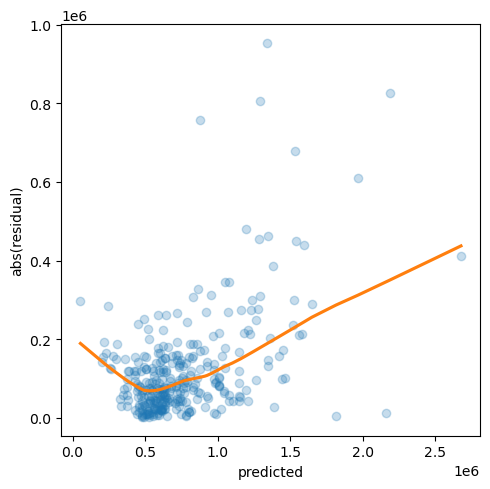

In [30]:
# The "regplot" in seaborn allows adding a lowess smoothing line to the scatterplot.
# The graph plots the absolute residuals versus the predicted values

# This is also known as a scale-location plot - a crucial diagnostic tool for checking regression assumptions.
# This plot helps us examine if the variance of residuals (errors) is constant across different predicted values, 
# which is the homoscedasticity assumption in regression analysis.

# Homoscedasticity:
    # The assumption of homoscedasticity (meaning “same variance”) is central to linear regression models.  
    # Homoscedasticity describes a situation in which the error term (that is, the “noise” or random disturbance in the 
    # relationship between the independent variables and the dependent variable) is the same across all values of the independent variables.
    # Heteroscedasticity (the violation of homoscedasticity) is present when the size of the error term differs across values 
    # of an independent variable.  
    # The impact of violating the assumption of homoscedasticity is a matter of degree, increasing as heteroscedasticity increases.


    # Creates a square plotting area of 5x5 inches:
fig, ax = plt.subplots(figsize=(5, 5))


    # "result_98105.fittedvalues" represents the values predicted by our model (x-axis)
    # "np.abs(result_98105.resid) shows the absolute values of residuals (y-axis)"
    # "alpha: 0.25" makes the points semi-transparent (helping us see overlapping points)
    # 'lowess=True' adds a locally weighted smoothing line (LOWESS) instead of a linear fit

    
    
sns.regplot(x=result_98105.fittedvalues, y=np.abs(result_98105.resid), 
            scatter_kws={'alpha': 0.25},
            line_kws={'color': 'C1'},
            lowess=True,
             ax=ax)

    # These lines label our axes to make the plot interpretable.
ax.set_xlabel('predicted')
ax.set_ylabel('abs(residual)')

    # We adjust the spacing around the plot and display it.
plt.tight_layout()
plt.show()


# LOWESS:
    # Locally Weighted Scatterplot Smoothing, sometimes called LOESS (locally weighted smoothing), 
    # is a popular tool used in regression analysis that creates a smooth line through a timeplot or scatter plot to help you 
    # to see relationship between variables and foresee trends.

    # LOWESS is typically used for:
    # Fitting a line to a scatter plot or time plot where noisy data values, sparse data points or weak interrelationships 
    # interfere with your ability to see a line of best fit.
    # Linear regression where least squares fitting doesn’t create a line of good fit or is too labor-intensive to use.
    # Data exploration and analysis in the social sciences, particularly in elections and voting behavior.



In [31]:
# Evidently, the variance of the residuals tends to increase for higher-valued homes but is also large for lower-valued homes. 
# This plot indicates that lm_98105 has heteroske‐ dastic errors

# Why Would a Data Scientist Care About Heteroskedasticity?
# Heteroskedasticity indicates that prediction errors differ for different ranges of the predicted value, and may suggest an incomplete model.
# For example, the heteroskedasticity in lm_98105 may indicate that the regression has left something unaccounted 
# for in high-and low-range homes.

# When interpreting this plot, we're looking for patterns. Ideally, we want to see:
#    - A relatively horizontal smoothing line, indicating consistent variance across predictions
#    - Points scattered randomly around this line
#    - No obvious trends or patterns in the spread of points
#    - If we see the spread of residuals increasing or decreasing with predicted values, or any other patterns, it might indicate 
#      violations of regression assumptions that need addressing.



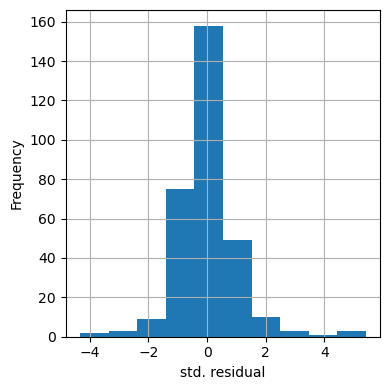

In [34]:
# We create the histogram of the standardized residuals for the lm_98105 regression:

fig, ax = plt.subplots(figsize=(4, 4))

# As a reminder:
    # influence = OLSInfluence(result_98105)
    # The "OLSInfluence" class from statsmodels calculates these diagnostic statistics 
    # from your regression model ("result_98105" in this case)

    # "influence.resid_studentized_internal":
    # contains the internally studentized residuals from our regression model. 
    # Studentized residuals are a standardized version of regular residuals, 
    # where each residual is divided by its estimated standard deviation. 
    # Think of it like converting test scores to z-scores - it puts everything on a comparable scale.
    # The term "internal" here means each residual is standardized using information from all observations, including itself. 
    # (There's also an "external" version that excludes the observation being standardized, which can be useful for outlier detection.)

    # We wrap these residuals in "pd.Series()" to create a pandas Series object. 
    # This gives us access to pandas' built-in plotting methods, including the ".hist()" method which creates a histogram. 
    # It's like putting our data into a special container that comes with useful tools for analysis and visualization.

    # he "ax=ax" parameter tells the histogram where to draw itself - 
    # in this case, on a specific subplot that was created earlier in the code.

pd.Series(influence.resid_studentized_internal).hist(ax=ax)

ax.set_xlabel('std. residual')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# When interpreting this histogram, we're looking for something approximately bell-shaped and centered around zero. 
# This would suggest our residuals follow a normal distribution, which is one of the key assumptions in linear regression. 
# Deviations from this pattern, like skewness or multiple peaks, might indicate problems with our model that need investigation.

# Here is a histogram of the standardized residuals for the lm_98105 regression. 
# The distribution has decidedly longer tails than the normal distribution and exhibits mild skewness toward larger residuals.

## 203 - Partial Residual Plots and Nonlinearity


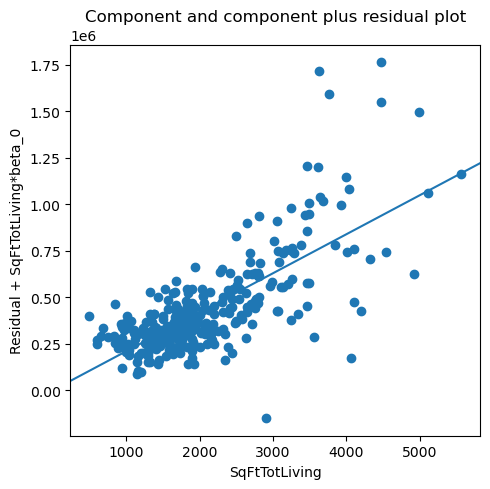

In [36]:
# The partial residual plots, also known as Component and Component-Plus-Residual (CCPR) plots, 
# which are valuable tools for checking the linearity assumption in regression analysis.

# This creates a CCPR plot specifically for the 'SqFtTotLiving' (Square Footage of Total Living Area) predictor variable.


  # Creates a square plotting area of 5x5 inches  

fig, ax = plt.subplots(figsize=(5, 5))


    # Creates the partial residual plot using statsmodels
    # "result_98105" is the fitted regression model
    # "SqFtTotLiving" is the predictor variable we're examining

fig = sm.graphics.plot_ccpr(result_98105, 'SqFtTotLiving', ax=ax)

plt.tight_layout()
plt.show()


    # plot_ccpr (from statsmodel)
# The function is designed to create Component and Component-Plus-Residual (CCPR) plots, 
# which are essential diagnostic tools in regression analysis.

# Basic syntax:
# statsmodels.graphics.plot_ccpr(results, exog_idx, ax=None)

    # results: 
    # This is your fitted model object (like the output from OLS.fit()). 
    # It contains all the regression results including coefficients, residuals, and fitted values. 
    # In our example, this was result_98105.

    # exog_idx: 
    # This parameter can take several forms:
    #     - A string with the name of the predictor variable (like 'SqFtTotLiving' in your example)
    #     - An integer index corresponding to the position of the variable in your predictor matrix
    #     - A list of indices if you want to create multiple CCPR plots

    # ax: 
    # This is an optional matplotlib axis object where the plot will be drawn. 
    # If you don't provide one, the function will create a new axis. 
    # In our example, we created one with plt.subplots().

    # The function returns the matplotlib figure object, which is why we see the line:
        # fig = sm.graphics.plot_ccpr(...)  # capturing the returned figure 

    # A helpful way to think about this function is that it's like asking for a specialized view of your data that shows: 
    # "How does this specific variable relate to my outcome, after accounting for all other variables?" 
    # The plot helps you see if your assumption of a linear relationship holds true for that particular predictor.




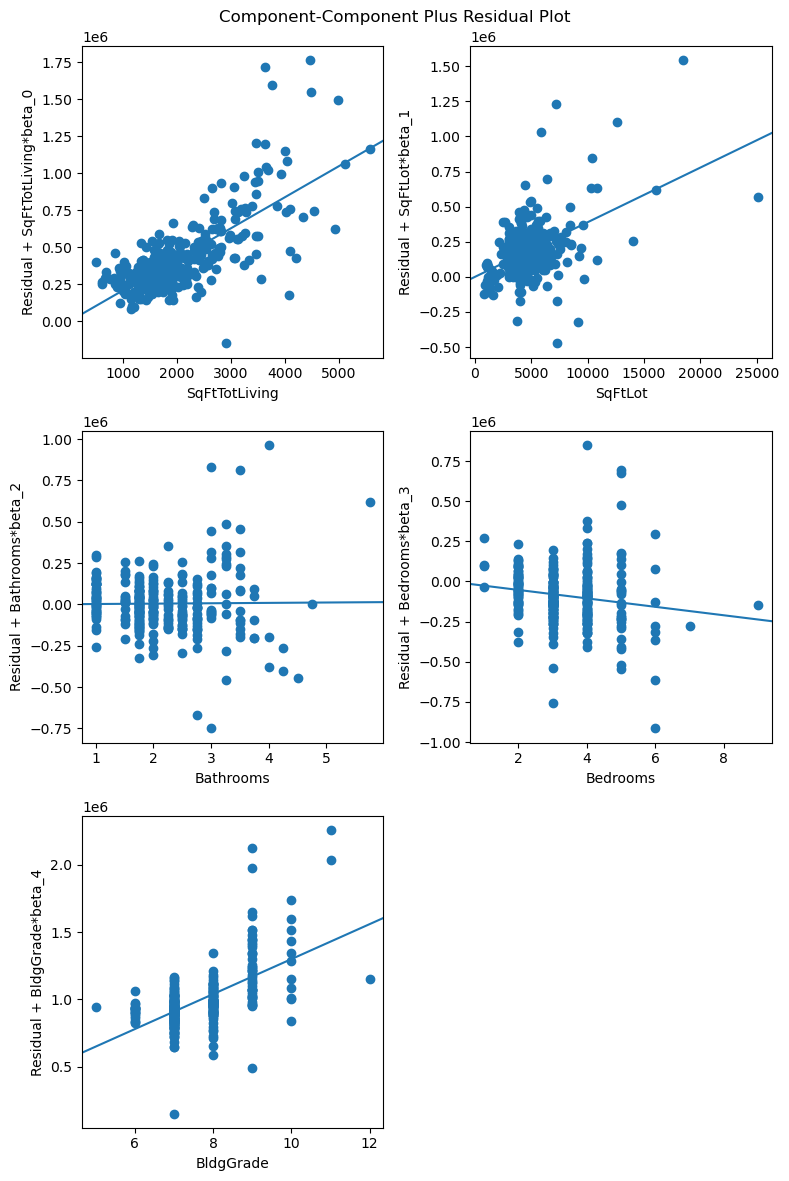

In [43]:
# Here we create a grid of CCPR plots for all predictors in your regression model. 
# This is particularly useful when you want to examine the relationships between multiple predictors 
# and your outcome variable simultaneously:


    # Create a figure with specific dimensions
fig = plt.figure(figsize=(8, 12))

    # Create the grid of CCPR plots for all predictors

    # The "plot_ccpr_grid function" is like having an automated assistant that creates individual CCPR plots 
    # for each predictor variable in your model, arranging them in a neat grid format. 
    # Think of it as creating a dashboard where you can see all your predictor relationships at once.

    # Parameters:
    #    - The fitted model (result_98105)
    #    - The fig parameter is your pre-created matplotlib figure

    # This allows to compare relationships across different predictors side by side
    # Spot patterns or issues that might only become apparent when viewing all relationships together
    # Save time compared to creating individual CCPR plots one by one

    # When you look at the resulting grid, each subplot shows:
    #    - The predictor variable's name as the title
    #    - The predictor values on the x-axis
    #    - The partial residuals on the y-axis
    #    - A fitted line showing the estimated relationship
    #    - Scattered points showing the actual partial residuals

fig = sm.graphics.plot_ccpr_grid(result_98105, fig=fig)

# HOW TO INTERPRET THEM?

# Think of a CCPR plot as a special lens that lets you see how each predictor variable relates to your outcome 
# while accounting for all other variables in your model. It's like isolating one relationship while controlling for everything else.

# When examining a CCPR plot, there are several key things to look for:
# First, focus on the overall pattern of the blue line in relation to the scattered points. 
# If your linear regression assumptions are met perfectly, you should see a straight line that captures the trend 
# in the scattered points well. This would tell you that your predictor has a truly linear relationship with the outcome.

# Remember that the goal isn't necessarily to achieve perfect linearity - 
# rather, it's to understand the true nature of the relationships in your data and model them appropriately. 
# Sometimes, what looks like a "problem" in a CCPR plot is actually revealing something important about the underlying relationship.

# SqFtTotLiving:
# There's a clear positive relationship - as square footage increases, home prices tend to increase too
# However, notice how the points fan out as we move right, creating a cone shape. 
# This suggests that price variability increases with house size - larger homes show more price variation than smaller ones
# The blue line appears to slightly underestimate prices for very large homes (above 4000 sq ft), 
# where we see several points clustering well above the line
# There's one notable outlier at around 3000 sq ft that falls well below the expected price range

# SqFtLot (lot size):
# There's also a positive relationship here, though it appears weaker than with living space
# The relationship looks more scattered, with many points deviating substantially from the trend line
# We see some very large lot sizes (around 20,000-25,000 sq ft) that don't command the premium the linear trend would predict
# The majority of properties cluster in the 0-10,000 sq ft lot size range, with relatively few larger lots

# These patterns suggest several important insights for your model:
#    - The increasing variance with house size might indicate that you should consider using weighted least squares regression 
#        or transforming your price variable (perhaps using a log transformation)
#    - The relationship with lot size might benefit from a non-linear transformation, as the effect of additional lot space appears 
#      to diminish for very large lots
#    - You might want to investigate whether there are specific characteristics of those high-value large homes that explain 
#      their premium prices


# Bathrooms:
# The relationship appears almost flat (the blue line is nearly horizontal), 
# suggesting that once we account for other features like square footage, the number of bathrooms alone doesn't strongly predict price
# However, the vertical spread of points shows considerable variation, forming distinct vertical "stripes" at each bathroom count
# Notably, homes with 3-4 bathrooms show the widest price variation, with some properties commanding significant premiums 
# while others sell for less than expected.
# The pattern suggests that bathroom count might be acting more as a proxy for overall home quality or features 
# rather than directly driving price


# Bedrooms:
# Surprisingly, there's a slight negative relationship (downward-sloping blue line)
# This might seem counterintuitive at first, but remember this is after controlling for total square footage
# What this tells us is that for homes of the same size, those with more bedrooms might actually sell for slightly less
# This could indicate that buyers in this market prefer homes where the square footage is allocated to larger rooms rather than more rooms
# The vertical "stripes" at each bedroom count show substantial variation in prices, particularly at 3-4 bedrooms where most homes cluster.

# The key insight from both plots is that raw room counts may be less important than how the space is used. 
# A home with fewer, but larger, rooms might command a premium over a similarly-sized home with more, but smaller, rooms. 
# This might reflect market preferences for open floor plans or more versatile living spaces.


# Building Grade:

# Overall Trend: There appears to be a positive linear relationship between Building Grade and the response variable, 
# as indicated by the upward slope of the blue line. 

# Linearity Assessment: The points show some deviation from the fitted line, but they generally follow the linear pattern. 
# This suggests that the linear assumption for this variable is reasonably appropriate, though there might be some mild non-linear patterns.

# Variability Pattern: We can observe that the spread of residuals (vertical scatter of points) appears to increase somewhat 
# at higher building grades (around 9-10), which might indicate some heteroscedasticity (non-constant variance) in the data.

# Influential Points: There are some points that appear to deviate substantially from the general pattern, 
# particularly some high values around building grades 9-10. These points might be worth investigating as potential influential observations.




In [45]:
    # HOW ARE CCPR MADE

# Component-Plus-Residual (CCPR) plots are powerful tools for checking the linearity assumption in multiple regression models.

# For a multiple regression model with several predictors (X₁, X₂, ..., Xₖ), suppose we want to examine the relationship 
# between one particular predictor (let's say X₄) and the response variable Y, while accounting for the effects of other predictors.

# The calculation process involves these steps:

# 1) First, we fit the full multiple regression model:
#    Y = β₀ + β₁X₁ + β₂X₂ + ... + βₖXₖ + ε
# 2) We obtain the residuals (e) from this model:
#    e = Y - (β₀ + β₁X₁ + β₂X₂ + ... + βₖXₖ)
#    These residuals represent the part of Y that isn't explained by our model.
# 3) For the predictor we're interested in (X₄), we calculate its component:
#    Component = β₄X₄
#    This represents the estimated effect of X₄ on Y according to our model.
# 4) We then create the Component-Plus-Residual by adding these together:
#    CPR = β₄X₄ + e

# The resulting plot shows X₄ on the x-axis and the CPR values on the y-axis.

# To understand why this is useful, consider what the CPR represents:
#    - The component (β₄X₄) shows the linear relationship we've modeled
#    - The residuals (e) show where the actual data points deviate from our model
#    - When we add them together, we get a picture that combines both the modeled relationship and the actual variation in the data


# If our linear assumption is appropriate, the points in the CCPR plot should roughly follow a straight line. 
# Any systematic deviation from linearity suggests we might need to consider transformations or non-linear terms in our model.



# QUESTION
# It's confusing as we consider only one component, but add the residuals for the whole model.

# Think about what we're trying to accomplish with a CCPR plot: we want to examine whether our assumption of a 
# linear relationship between X₄ and Y is reasonable. But here's the key insight - we want to do this while taking into account 
# the full complexity of our model.

# When we add the full model's residuals, we're actually doing something very important: 
# we're looking at the relationship between X₄ and Y after accounting for all other variables. 

# The beauty of adding the full model's residuals is that it shows us the "partial relationship" between X₄ and Y 
# in the context of the complete model. This is more realistic than looking at X₄'s effect in isolation because in real life, 
# all these variables work together.

# If we only looked at the component without the full residuals, we might miss important patterns that emerge from the interplay of variables.
# The residuals, even if they're large due to other factors, help us see if our linear assumption for X₄ holds up in the real, 
# messy context of our full model.

# when we're specifically trying to examine the relationship between X₄ and Y, having our visualization cluttered by problems from X₁ can be misleading and unhelpful
# This is where more sophisticated diagnostic approaches come in. One alternative is the partial residual plot 
# (also called added-variable plot or adjusted variable plot), which specifically looks at:
#    - The residuals from regressing Y on all variables EXCEPT X₄
#    - The residuals from regressing X₄ on all other X variables
# By doing this, we "clean out" the noise from other variables and get a clearer picture of X₄'s unique relationship with Y.

# This connects to a broader principle in statistical diagnosis: when we're investigating one specific aspect of our model, 
# we want to control or account for other sources of variation rather than letting them confound our analysis. 
# Traditional CCPR plots, while useful in some contexts, can sometimes violate this principle by allowing problems with other variables 
# to "leak" into our examination of a specific predictor.


